In [1]:
import os
from chart_studio import plotly
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
import math
import time
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Para este análisis se utilizarán los datos longitudinales que hacen referencia a las acciones de Amazon desde 2006 hasta 2018.

In [2]:
amazon = pd.read_csv('amazon.csv', index_col='Date', parse_dates=['Date'])
amazonNI = pd.read_csv('amazon.csv', parse_dates=['Date'])

In [3]:
amazon.head(10)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN
2006-01-10,46.41,46.75,45.36,45.65,9686957,AMZN
2006-01-11,45.65,45.70,44.26,44.93,8497383,AMZN
2006-01-12,44.79,45.09,44.09,44.36,5818301,AMZN
2006-01-13,44.48,44.85,44.00,44.40,4432237,AMZN


In [4]:
amazonNI.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN
5,2006-01-10,46.41,46.75,45.36,45.65,9686957,AMZN
6,2006-01-11,45.65,45.70,44.26,44.93,8497383,AMZN
7,2006-01-12,44.79,45.09,44.09,44.36,5818301,AMZN
8,2006-01-13,44.48,44.85,44.00,44.40,4432237,AMZN
9,2006-01-17,43.95,44.32,43.66,44.00,5635225,AMZN


Se aprecia como las acciones de Amazon aumentan en todas sus componentes con el paso de los años.

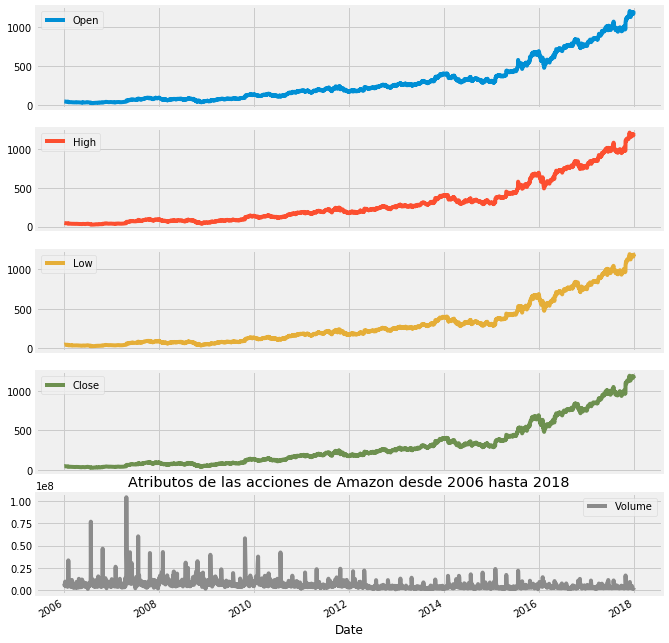

In [5]:
amazon['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('Atributos de las acciones de Amazon desde 2006 hasta 2018')
plt.show()

Se puede ver la variación porcentual para analizar el rendimiento de las acciones

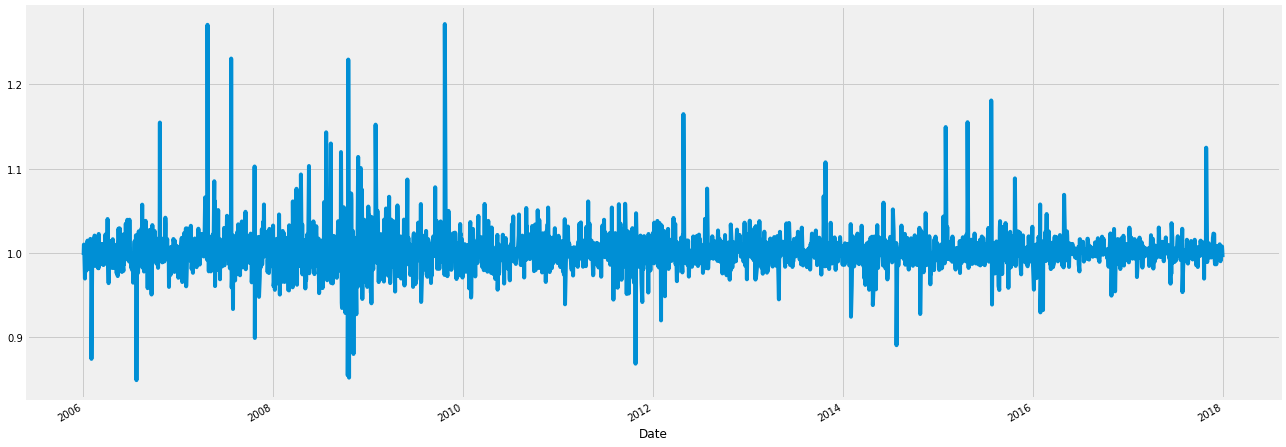

In [6]:
amazon['Change'] = amazon.High.div(amazon.High.shift())
amazon['Change'].plot(figsize=(20,8))

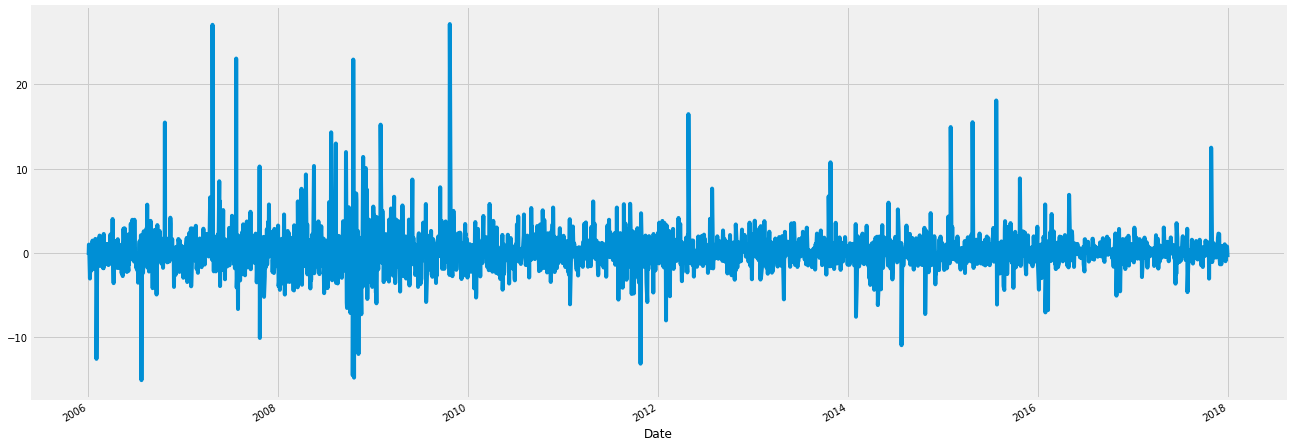

In [7]:
amazon['Return'] = amazon.Change.sub(1).mul(100)
amazon['Return'].plot(figsize=(20,8))

Los tres componentes que serán fundamentales para la serie temporal son: tendencias, estacionalidad y ruido. Se definen de la siguiente manera:
 - Tendencia: Comportamiento o movimiento a largo plazo
 - Estacionalidad: Patrón periódico claro de una serie temporal
 -  Ruido: Valores atípicos o ausentes

Ahora, vemos gráficamente los elementos temporales de las acciones de Amazon

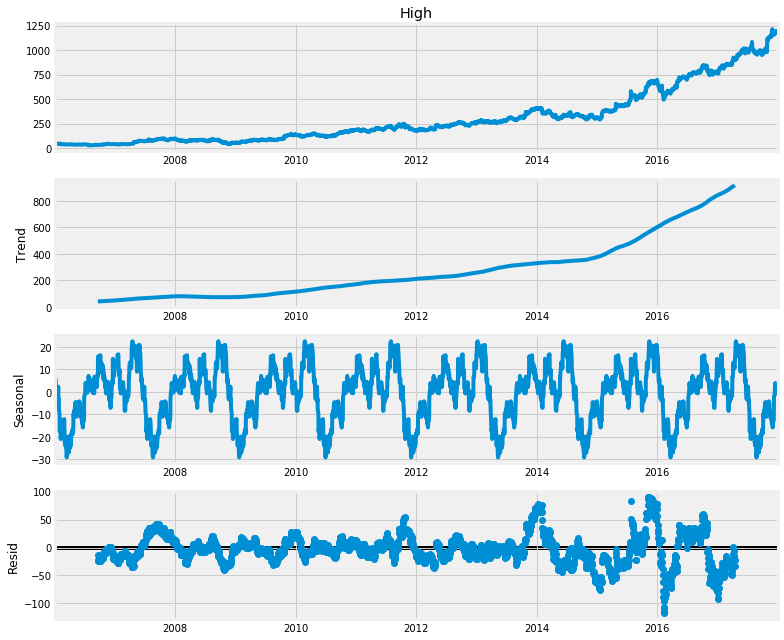

In [8]:
rcParams['figure.figsize'] = 11, 9
decomposed_amazon_volume = sm.tsa.seasonal_decompose(amazon["High"],freq=360) 
figure = decomposed_amazon_volume.plot()
plt.show()

En cuanto a la tendencia de Amazon, es ascendente con el paso de los años aunque a partir de 2015 la pendiente es más pronunciada. Existe variación estacional con un patrón aparentemente claro y respecto a los residuos, no siguen uniformidad por lo que existen valores atípicos o faltantes.

In [9]:
adf = adfuller(amazon["Volume"])
print("p-value of amazon: {}".format(float(adf[1])))

p-value of amazon: 2.7273708415137513e-05


Como el p-valor es inferior a 0,05, se rechaza la hipótesis nula y no se trata de un recorrido aleatorio.

MODELO ARIMA

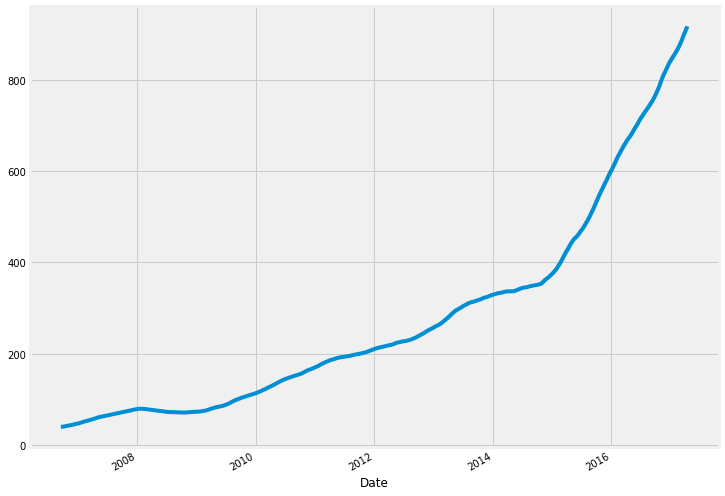

In [10]:
decomposed_amazon_volume.trend.plot()

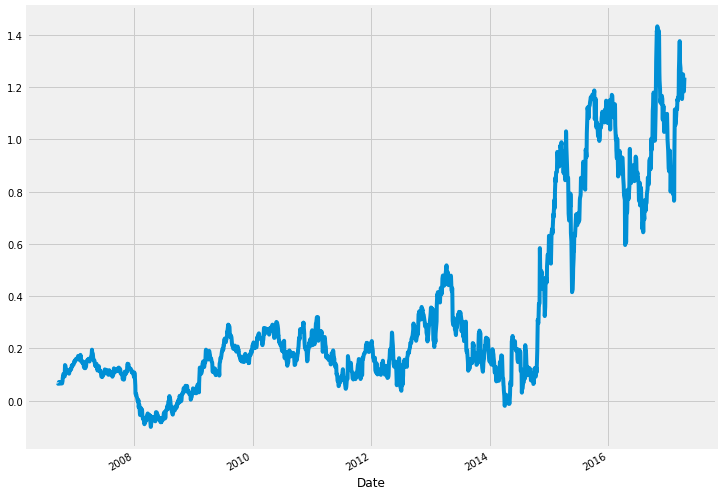

In [11]:
decomposed_amazon_volume.trend.diff().plot()

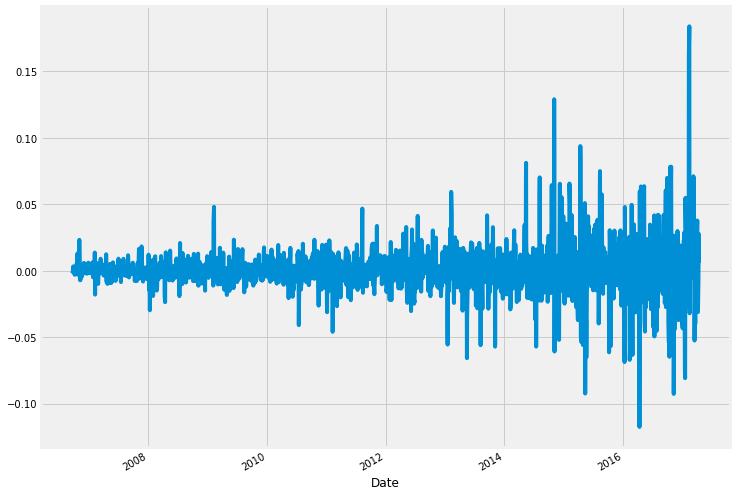

In [12]:
decomposed_amazon_volume.trend.diff().diff().plot()

Se observa que tras la diferenciación la serie pierde la tendencia, siendo claramente estacionaria en media. 

In [13]:
df = pd.DataFrame(amazonNI)

In [14]:
# generamos el dataframe completo de nuestro análisis

df["Close_diff"] = df["Close"].diff()
df["Close_2_diff"] = df["Close_diff"].diff()
df["Date"] = pd.to_datetime(df["Date"], format = "%Y")
df.set_index("Date", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head()
y = df["Close"]
y_diff = df["Close_diff"]
y_2_diff = df["Close_2_diff"]


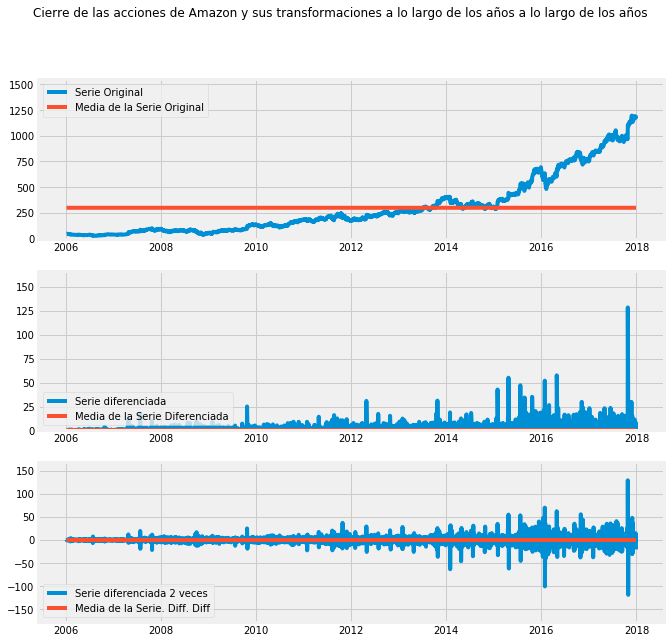

In [15]:
# separar x y la y para el gráfico
x = df.index


y_media = [np.mean(y) for _ in y]
y_diff_media = [np.mean(y_diff) for _ in y_diff]
y_2_diff_mean = [np.mean(y_2_diff) for _ in y_2_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes
# tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 7.
ax2.plot(x, y_diff, label = "Serie diferenciada")
ax2.plot(x, y_diff_media, label = "Media de la Serie Diferenciada")
ax2.set_ylim(0, np.max(y_diff)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_2_diff, label = "Serie diferenciada 2 veces")
ax3.plot(x, y_2_diff_mean, label = "Media de la Serie. Diff. Diff")
ax3.set_ylim(np.min(y_2_diff)*1.5, np.max(y_2_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Cierre de las acciones de Amazon y sus transformaciones a lo largo de los años a lo largo de los años");

In [16]:
for serie, nombre_serie in zip([y, y_diff, y_2_diff], ["Serie Original", "Serie diferenciada", "Serie. Diff. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: 2.9638636401424936

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 1.0

------------------------------------------------------------------
Estamos trabajando con la serie Serie diferenciada

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -10.091680824769897

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 1.1178880015096339e-17

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Diff. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -16.287658615766745

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 3.3628716716402475e-29



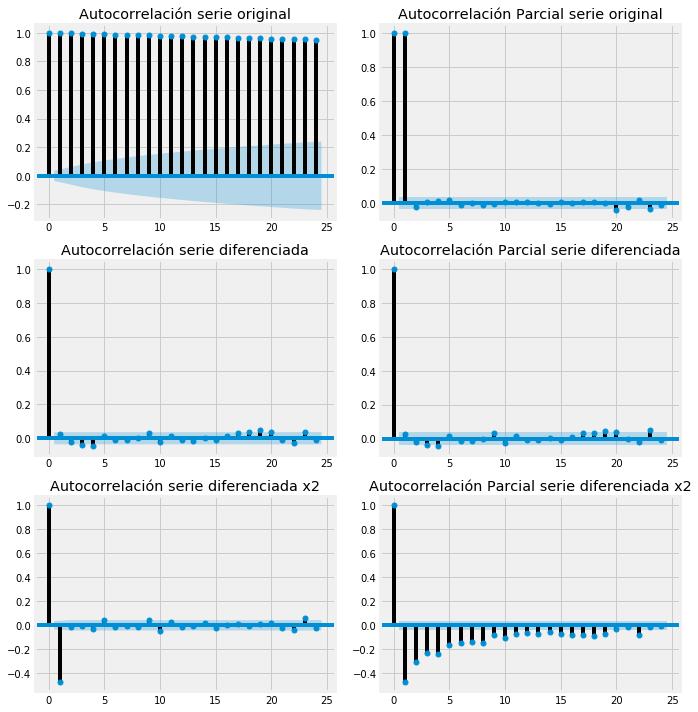

In [17]:

LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación serie original")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial serie original")

plot_acf(y_diff, ax = ax3, lags = LAGS, title = "Autocorrelación serie diferenciada")
plot_pacf(y_diff, ax = ax4, lags = LAGS, title = "Autocorrelación Parcial serie diferenciada")

plot_acf(y_2_diff, ax = ax5, lags = LAGS, title = "Autocorrelación serie diferenciada x2")
plot_pacf(y_2_diff, ax = ax6, lags = LAGS, title = "Autocorrelación Parcial serie diferenciada x2")

fig.tight_layout()

In [18]:
serie_a_predecir = y_diff

y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

Como vemos arriba, después de la diferenciación de segundo orden, el valor p cae por encima del umbral aceptable. Por lo tanto, podemos considerar que el orden de diferenciación ("d") es 2. Esto se corresponde bien con el gráfico de la línea de autocorrelación visto anteriormente. Sin embargo, el valor p para el primer orden está mucho más cerca del umbral, por lo que, para ser conservadores, consideraremos "d" como 1 y veremos cómo funciona el modelo.

El siguiente paso en el modelo ARIMA es calcular "p", o el orden del modelo autorregresivo. Podemos inspeccionar el gráfico de autocorrelación parcial, que mide la correlación entre los datos de la serie temporal y un determinado retardo. Basándonos en la presencia o ausencia de correlación, podemos determinar si el retardo o el orden son necesarios o no.


Si los datos proceden de un modelo ARIMA(p,d,0) o ARIMA(0,d,q), entonces las gráficas del ACF y el PACF son útiles para determinar el valor de p o q.

Vemos que hay todos los picos en el ACF son significativos. En el PACF, hay dos picos significativos.

Podemos ignorar un pico significativo en cada gráfica si está justo fuera de los límites, y no en los primeros retardos. Después de todo, la probabilidad de que una pico sea significativo por casualidad es de una en veinte, y estamos trazando 22 picos en cada gráfico. 


En ambos gráficos, vemos que el primer retraso es el más significativo. Por lo tanto, consideramos que "p" es 1.

Por último, "q" puede estimarse de forma similar observando el gráfico ACF en lugar del gráfico PACF. Observando el número de rezagos que cruzan el umbral, podemos determinar qué parte del pasado sería lo suficientemente significativa como para considerarla para el futuro. Los que tienen una alta correlación contribuyen más y serían suficientes para predecir los valores futuros. A partir de los gráficos anteriores, el parámetro de la media móvil (MA) puede fijarse en 2.

Así, nuestro modelo ARIMA final puede definirse como ARIMA(p=1, d=1,q= 2)


In [19]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


In [20]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:17160.161369109814
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:17156.771446411614


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_

ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:17153.364982607472
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:19021.646515910055


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:17149.82771192457


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:17146.513797017305
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:21984.268118002896


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:19018.42731232273


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provid

ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:17155.347796780516
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:17162.095836316606
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:17158.973616331736


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:17154.31785884918
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:18261.255555497148


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:17151.826472473054


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:17148.34990960706
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:20379.754662182426


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:18259.008163451515


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:17399.41744477974
ARIMA(2, 0, 0)x(0, 0, 0, 0)12 - AIC:17158.701508466696


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(2, 0, 1)x(0, 0, 0, 0)12 - AIC:17160.224652664983


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provid

ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:17121.206785489594
ARIMA(2, 1, 0)x(0, 0, 0, 0)12 - AIC:17979.5163711554
ARIMA(2, 1, 1)x(0, 0, 0, 0)12 - AIC:17153.760401267224


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:17150.169555062548
ARIMA(2, 2, 0)x(0, 0, 0, 0)12 - AIC:19639.296140098635


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provid

ARIMA(2, 2, 1)x(0, 0, 0, 0)12 - AIC:17983.791359647545


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(2, 2, 2)x(0, 0, 0, 0)12 - AIC:17164.718748404874
La búsqueda de parámetros no ha llevado 0.18986483812332153 minutos!


In [21]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (2, 0, 2), 
Con un AIC de 17121.206785489594


In [22]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [23]:
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4788      0.004    340.727      0.000       1.470       1.487
ar.L2         -0.9895      0.004   -253.704      0.000      -0.997      -0.982
ma.L1         -1.4839      0.006   -228.546      0.000      -1.497      -1.471
ma.L2          0.9807      0.006    166.187      0.000       0.969       0.992
sigma2        31.6586      0.264    119.729      0.000      31.140      32.177


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals





Vemos de la tabla de coeficientes, que a pesar de seleccionar el modelo con el mejor AIC, tenemos parametros que no son significativos porque su p - valor es superior a 0.05.



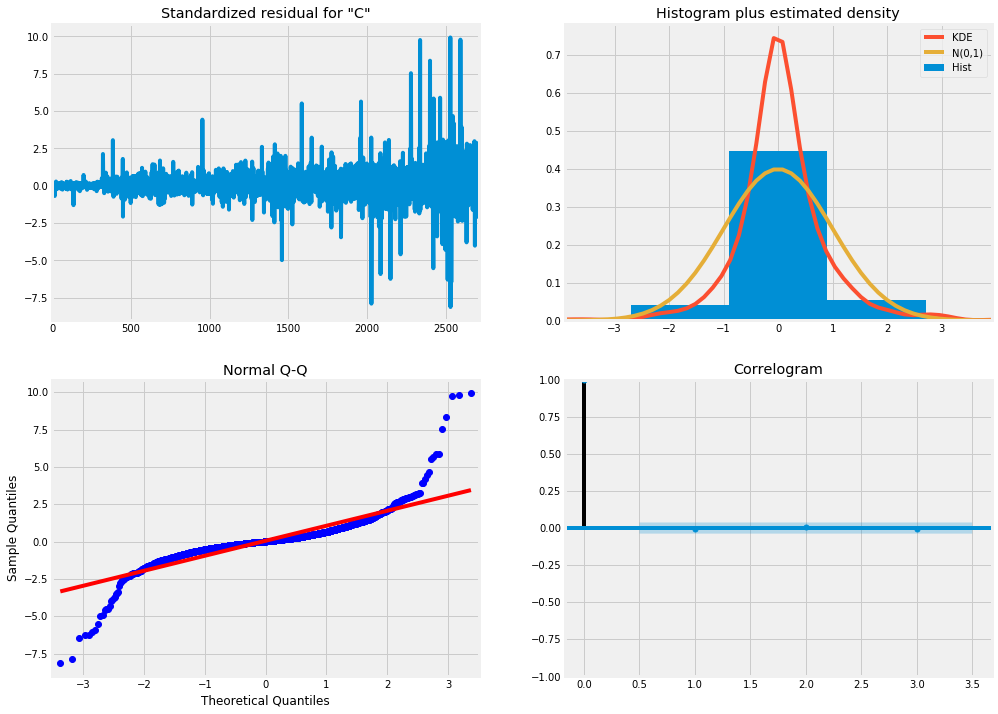

In [24]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);



Interprentado los gráficos podemos observar lo siguiente:

    - Arriba a la izquierda: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.
    - Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
    - Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos, es decir el modelo no ha sido capaz de reproducir el patrón de comportamiento sistemático de la serie y habría que reformularlo.
    - Abajo a la izquierda: la distrbución ordenada de los residuos se quiere parecer a una normal pero dista de ello.



In [25]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()


/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [26]:
y_pred = pred_ci.iloc[:, 0]

In [27]:
#RMSE

rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (2, 0, 2), ha dado un rmse en test de 17.79


In [28]:
param=(2,1,2)
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = param,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results2 = mod.fit()

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [29]:
results = mod.fit()

print(results2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8105      0.339     -2.394      0.017      -1.474      -0.147
ar.L2         -0.0064      0.013     -0.508      0.611      -0.031       0.018
ma.L1         -0.1907      0.342     -0.558      0.577      -0.861       0.480
ma.L2         -0.8127      0.343     -2.370      0.018      -1.485      -0.141
sigma2        32.4260      0.285    113.871      0.000      31.868      32.984


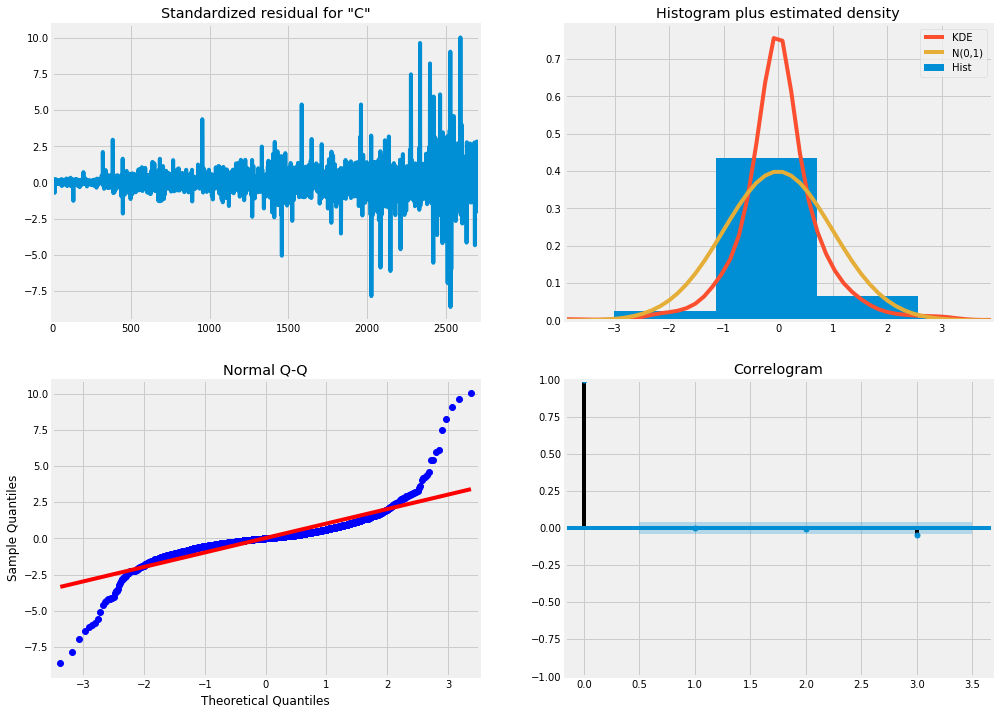

In [30]:
results2.plot_diagnostics(figsize = (15, 12), lags = 3);

In [31]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results2.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [32]:
y_pred = pred_ci.iloc[:, 0]

In [33]:
#RMSE
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(param, round(rmse, 2)))

El modelo ARIMA con los parametros (2, 1, 2), ha dado un rmse en test de 17.41


SARIMA

In [39]:
import statsmodels.api as sm
import pmdarima as pm

In [40]:
model = pm.auto_arima(df["Close"], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=9.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=22155.059, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21286.800, Time=4.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=11.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=22155.300, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=20887.697, Time=11.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=32.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=15.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=20887.362, Time=7.90 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=21285.612, Time=2.85 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=24.85 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=20887.643, Time=12.33 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=51.89 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=20887.362, Time=7.10 sec

Best model:  ARIMA(0,1,0)(2,1,0)[

In [67]:
param=(0,1,0)
param_seasonal=(2,1,0,12)
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = param,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6809      0.010    -68.138      0.000      -0.701      -0.661
ar.S.L24      -0.3704      0.009    -39.711      0.000      -0.389      -0.352
sigma2        87.3688      0.928     94.191      0.000      85.551      89.187


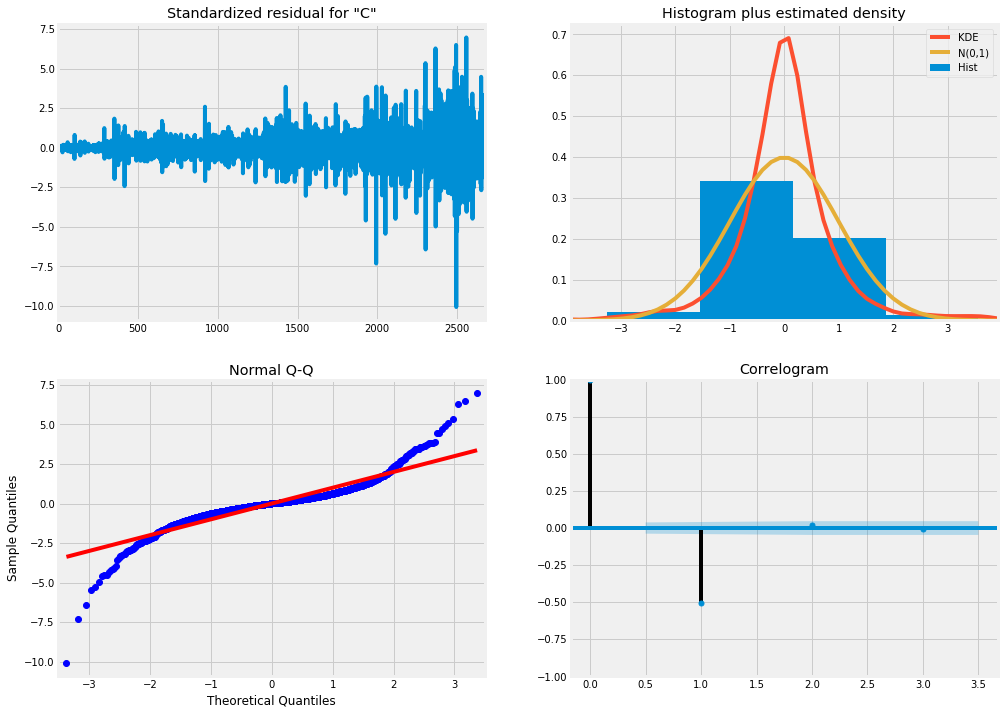

In [68]:
resultsX = mod.fit()
print(resultsX.summary().tables[1])
resultsX.plot_diagnostics(figsize = (15, 12), lags = 3);

In [69]:
pred = resultsX.predict(start=450, end=516)
print(results.summary())
print(pred.describe())

                                     SARIMAX Results                                      
Dep. Variable:                         Close_diff   No. Observations:                 2715
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -9785.432
Date:                            Mon, 27 Jun 2022   AIC                          19576.864
Time:                                    09:20:56   BIC                          19594.542
Sample:                                         0   HQIC                         19583.259
                                           - 2715                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6809      0.010    -68.138      0.000      -0.701      -0.661
ar.S.L24      -0.3704      0.009   

In [70]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = resultsX.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

/home/amanda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [71]:
y_pred = pred_ci.iloc[:, 0]
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("El modelo SARIMAX con los parametros {}x{} , ha dado un rmse en test de {}".format(param, param_seasonal, round(rmse, 2)))

El modelo SARIMAX con los parametros (0, 1, 0)x(2, 1, 0, 12) , ha dado un rmse en test de 1253.84


--------------------------------------------

EXPLICABILIDAD

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('fifa.csv')


In [84]:
data.head(10)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0
5,15-06-2018,Iran,Morocco,1,36,8,2,5,1,2,...,3,0,0,Yes,90.0,Group Stage,No,0,NaN,NaN
6,15-06-2018,Portugal,Spain,3,39,8,3,2,3,4,...,1,0,0,No,4.0,Group Stage,No,0,NaN,NaN
7,15-06-2018,Spain,Portugal,3,61,12,5,5,2,5,...,1,0,0,Yes,24.0,Group Stage,No,0,NaN,NaN
8,16-06-2018,France,Australia,2,51,12,5,4,3,5,...,1,0,0,Yes,58.0,Group Stage,No,0,NaN,NaN
9,16-06-2018,Australia,France,1,49,4,1,2,1,1,...,3,0,0,No,62.0,Group Stage,No,0,1.0,81.0


In [86]:
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test

In [98]:
# build model - Xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel()) 

# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)

# Performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[10:39:12] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[10:39:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 65.38%


Ahora comenzamos nuestro análisis para desglosar este modelo y hacer transparente su funcionamiento.

SHAP

In [110]:
import shap

ImportError: cannot import name 'cached_property'

In [ ]:
# Generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value